In [3]:
import pandas as pd
import numpy as np

In [4]:
from importlib.machinery import SourceFileLoader

tools = SourceFileLoader("tools", "../tools.py").load_module()

from tools import write_to_file

In [5]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [6]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

General & Temporial Analysis
===================

In [8]:
df = pd.read_csv("../data/prisoners_dilemma_articles_meta_data.csv")

In [9]:
df = df.replace("None", np.nan)

**Total number of articles.**

In [10]:
total_articles = len(df["title"].unique())


**Unique titles**

In [11]:
len(df["title"].unique()), len(df["unique_key"].unique())


(3089, 3167)

**Numbers of author and year range.**

In [12]:
number_of_authors = len(df["author"].unique())


In [14]:
for data, name in zip(
    [total_articles, number_of_authors], ["total_articles.txt", "number_of_authors.txt"]
):
    write_to_file(metric=data, filename=name)


Provenance
----------

The total number of articles is given above. Here we can illustrate the provenance of these articles.
Thus we can see from which journal they have been collected and how many articles have been added by us. The table below shows the number of articles for each provenance.

In [15]:
provenance_size = (
    df.groupby(["unique_key", "provenance"])
    .size()
    .reset_index()
    .groupby("provenance")
    .size()
)


In [16]:
write_to_file(metric=provenance_size["Manual"], filename="prov_manual.txt")


In [53]:
percentage = provenance_size.apply(lambda x: round(x / total_articles * 100, 2))


In [55]:
provenance_table = pd.concat([provenance_size, percentage], axis=1)

In [59]:
provenance_table = pd.concat([provenance_size, percentage], axis=1)
provenance_table.columns = ["# of Articles", "Percentage"]
provenance_table = provenance_table.sort_values(by="# of Articles")


In [46]:
provenance_table


,# of Articles,Percentage
provenance,,
Manual,89,2.88
IEEE,295,9.55
PLOS,482,15.60
Springer,572,18.52
Nature,673,21.79
arXiv,1056,34.19


In [60]:
provenance_table.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &  \\# of Articles &  Percentage \\\\\nprovenance &                &             \\\\\n\\midrule\nManual     &             89 &        2.88 \\\\\nIEEE       &            295 &        9.55 \\\\\nPLOS       &            482 &       15.60 \\\\\nSpringer   &            572 &       18.52 \\\\\nNature     &            673 &       21.79 \\\\\narXiv      &           1056 &       34.19 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [62]:
write_to_file(metric=provenance_table.to_latex().replace(' \\\\\n', '\%\\\\\n').replace(' \%\\\\\n', ' \\\\\n')
              , filename="provenance_table.tex")


Temporal Analysis
-----------------

In [23]:
colors = ["darkblue", "darkred", "darkgreen"]


In [24]:
yearly_provenance = (
    df.groupby(["unique_key", "provenance", "date"])
    .size()
    .reset_index()
    .groupby(["provenance", "date"])
    .size()
)


In [25]:
yearly_df = (
    df.groupby(["unique_key", "date"]).size().reset_index().groupby("date").size()
)


Text(0.5,1,"Articles per Year (N = 3089) Prisoner's Dilemma")

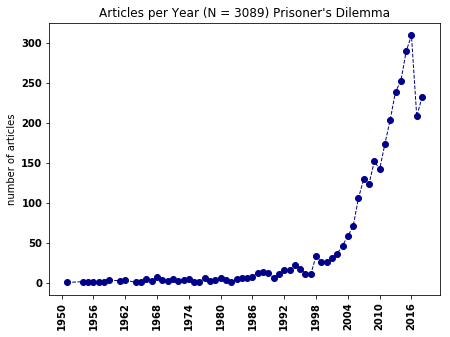

In [26]:
fig = plt.figure(figsize=(7, 5))

plt.plot(yearly_df, "--o", color=colors[0], zorder=1, linewidth=1)
plt.xticks(np.arange(1950, 2018, step=6), rotation=90)

plt.ylabel("number of articles")
plt.savefig("../../assets/images/timeline.pdf", bbox_inches="tight")
plt.title("Articles per Year (N = {}) Prisoner's Dilemma".format(total_articles))


**Fitting and forecasting**

In [27]:
x = range(37)
y = yearly_df[1980:2016].values


In [28]:
from scipy import optimize


def func(x, a, b, c):
    return a * np.exp(-b * x) + c


params, params_covariance = optimize.curve_fit(func, x, y, p0=[0, 0, 0])


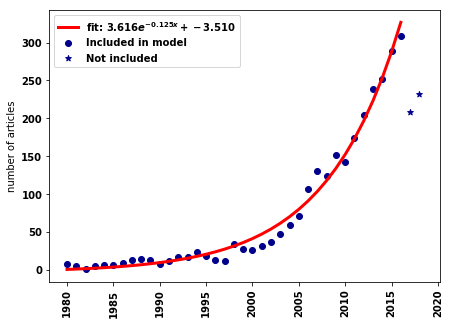

In [29]:
plt.figure(figsize=(7, 5))
plt.scatter(
    yearly_df[1980:2016].index,
    y,
    color=colors[0],
    zorder=1,
    linewidth=1,
    label="Included in model",
)
plt.plot(
    yearly_df[1980:2016].index,
    func(x, params[0], params[1], params[2]),
    label=r"fit: $ %5.3f e^{%5.3f x} +%5.3f$" % tuple(params),
    color="red",
    zorder=2,
    linewidth=3,
)
plt.scatter(
    yearly_df[2017:2018].index,
    yearly_df[2017:2018].values,
    color=colors[0],
    zorder=1,
    linewidth=1,
    marker="*",
    label="Not included",
)
plt.xticks(rotation=90)
plt.legend(loc="best")

plt.ylabel("number of articles")
plt.savefig("../../assets/images/fitting.pdf", bbox_inches="tight")


In [30]:
xn = range(37, 42)


In [31]:
forecasting = [round(func(x_v, *params)) for x_v in xn]


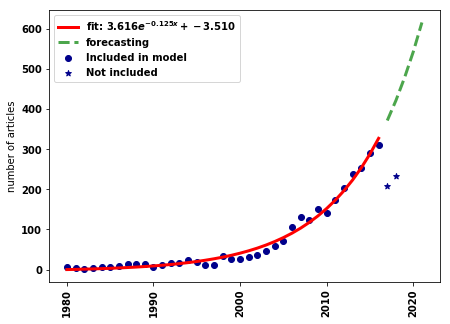

In [32]:
plt.figure(figsize=(7, 5))
plt.scatter(
    yearly_df[1980:2016].index,
    y,
    color=colors[0],
    zorder=1,
    linewidth=1,
    label="Included in model",
)
plt.plot(
    yearly_df[1980:2016].index,
    func(x, params[0], params[1], params[2]),
    label=r"fit: $ %5.3f e^{%5.3f x} +%5.3f$" % tuple(params),
    color="red",
    zorder=2,
    linewidth=3,
)
plt.plot(
    range(2017, 2022),
    forecasting,
    label="forecasting",
    color="green",
    zorder=2,
    linewidth=3,
    alpha=0.7,
    linestyle="--",
)
plt.scatter(
    yearly_df[2017:2018].index,
    yearly_df[2017:2018].values,
    color=colors[0],
    zorder=1,
    linewidth=1,
    marker="*",
    label="Not included",
)

plt.xticks(rotation=90)

plt.legend(loc="best")

plt.ylabel("number of articles")
plt.savefig("../../assets/images/forecasting.pdf", bbox_inches="tight")


In [33]:
index = range(2017, 2022)
forecasting_table = pd.DataFrame(forecasting, columns=["Forecast"], index=index)


In [34]:
file = open("../../assets/predictions.tex", "w")
file.write("{}".format(forecasting_table.to_latex()))
file.close()


Av. publication
------

The rate is calculated as the ratio of number of total articles and the number of years of publication.
Thus:
    $$ \text{rate}= \frac{\text{number of articles}}{\text{years of publication}}$$

In [35]:
(yearly_df.values.sum() / yearly_df.count())


49.40625

In [39]:
rates = [np.round(yearly_df.values.sum() / yearly_df.count())]
for api in ["IEEE", "Nature", "PLOS", "Springer", "arXiv"]:
    rates.append(np.round(yearly_provenance[api].values.sum() / yearly_df.count()))


In [40]:
rates_table = pd.DataFrame(
    rates,
    ["Overall", "IEEE", "Nature", "PLOS", "Springer", "arXiv"],
    columns={"Average Yearly publication"},
)


In [41]:
rates_table = rates_table.sort_values(by="Average Yearly publication")
rates_table


,Average Yearly publication
IEEE,5.0
PLOS,8.0
Springer,9.0
Nature,11.0
arXiv,16.0
Overall,49.0


In [42]:
write_to_file(metric=rates_table.to_latex(), filename="rates_table.tex")


Comparison Table
----------------

In [63]:
auction_df = pd.read_csv("../data/auction_theory_articles_meta_data.csv")
anarchy_df = pd.read_csv("../data/price_of_anarchy_articles_meta_data.csv")


In [64]:
general_data = []
for data in [df, auction_df, anarchy_df]:
    total_size = len(data["title"].unique())
    num_authors = len(data["author"].unique())

    provenance = (
        data.groupby(["unique_key", "provenance"])
        .size()
        .reset_index()
        .groupby("provenance")
        .size()
    )
    provenance_percent = provenance.apply(lambda x: round(x / total_size * 100, 2))

    yearly = (
        data.groupby(["unique_key", "date"]).size().reset_index().groupby("date").size()
    )
    av_publications = np.round(yearly.values.sum() / yearly.count())

    general_data.append(
        (
            total_size,
            num_authors,
            provenance_percent.index,
            provenance_percent.values,
            av_publications,
        )
    )


In [65]:
provenance_for_table = [
    {key: value for key, value in zip(general_data[i][2], general_data[i][3])}
    for i in range(3)
]


In [66]:
provenance_for_table


[{'IEEE': 9.55,
  'Manual': 2.88,
  'Nature': 21.79,
  'PLOS': 15.6,
  'Springer': 18.52,
  'arXiv': 34.19},
 {'IEEE': 7.46, 'Nature': 5.89, 'Springer': 37.63, 'arXiv': 51.36},
 {'IEEE': 30.66,
  'Manual': 0.13,
  'Nature': 24.63,
  'PLOS': 1.74,
  'Springer': 38.02,
  'arXiv': 8.84}]

In [67]:
frame = {
    "Num. Articles": [general_data[i][0] for i in range(3)],
    "Num. Authors": [general_data[i][1] for i in range(3)],
    r"Nature (%)": [topic["Nature"] for topic in provenance_for_table],
    r"IEEE (%)": [topic["IEEE"] for topic in provenance_for_table],
    r"Springer (%)": [topic["Springer"] for topic in provenance_for_table],
    r"arXiv (%)": [topic["arXiv"] for topic in provenance_for_table],
    r"PLOS (%)": [
        provenance_for_table[0]["PLOS"],
        "-",
        provenance_for_table[2]["PLOS"],
    ],
    r"Manual (%)": [
        provenance_for_table[0]["Manual"],
        "-",
        provenance_for_table[-1]["Manual"],
    ],
    "Av. Yearly Publication": [general_data[i][-1] for i in range(3)],
}


In [68]:
table = pd.DataFrame.from_dict(frame)
table.index = ["Prisoner's Dilemma", "Auction Games", "Price of Anarchy"]


In [69]:
columnsTitles = [
    "Num. Articles",
    "Num. Authors",
    r"Manual (%)",
    r"PLOS (%)",
    r"Nature (%)",
    r"Springer (%)",
    r"IEEE (%)",
    r"arXiv (%)",
    "Av. Yearly Publication",
]

table = table.reindex(columns=columnsTitles)


In [70]:
table


,Num. Articles,Num. Authors,Manual (%),PLOS (%),Nature (%),Springer (%),IEEE (%),arXiv (%),Av. Yearly Publication
Prisoner's Dilemma,3089,5811,2.88,15.6,21.79,18.52,9.55,34.19,49.0
Auction Games,3444,5362,-,-,5.89,37.63,7.46,51.36,93.0
Price of Anarchy,747,1315,0.13,1.74,24.63,38.02,30.66,8.84,39.0


In [71]:
write_to_file(metric=table.to_latex(), filename="prelimanary_comparison.tex")


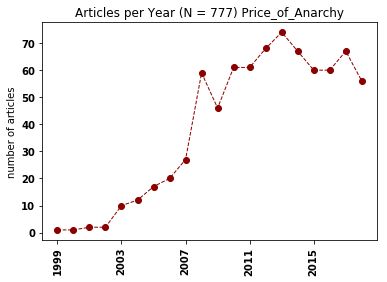

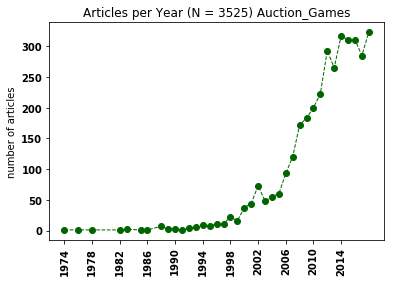

In [72]:
i = 1
for data, label in zip([anarchy_df, auction_df], ["Price_of_Anarchy", "Auction_Games"]):
    total = len(data["unique_key"].unique())

    yearly = (
        data.groupby(["unique_key", "date"]).size().reset_index().groupby("date").size()
    )

    fig = plt.figure()

    plt.plot(yearly.index, yearly.values, "--o", color=colors[i], zorder=1, linewidth=1)
    plt.xticks(np.arange(min(yearly.index), 2018, step=4), rotation=90)

    plt.ylabel("number of articles")
    plt.title("Articles per Year (N = {}) {}".format(total, label))
    plt.savefig("../../assets/images/{}.pdf".format(label), bbox_inches="tight")
    i += 1
